# JAX Learning Notes
--------------------
# Tutorial JAX 101

## JAX As Accelerated Numpy

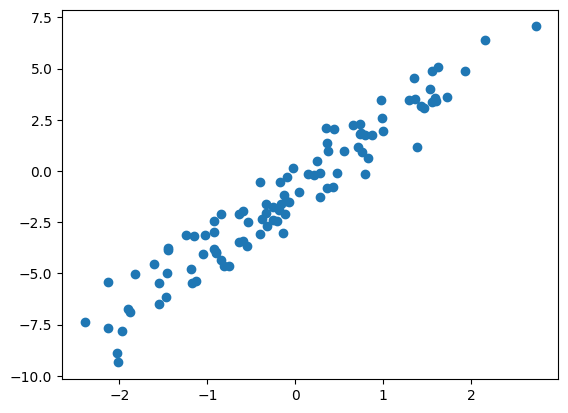

In [1]:
# Linear Regression Example

import jax
from jax import numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys)


In [3]:
def model(theta, x):
    """Computes wx + b on a batch of input x."""
    w, b = theta
    return w * x + b
def loss_fn(theta, x, y):
    prediction = model(theta, x)
    return jnp.mean((prediction-y)**2)
@jax.jit
def update(theta, x, y, lr=0.1):
    return theta - lr * jax.grad(loss_fn)(theta, x, y)

loss: 10.60
loss: 0.89
loss: 0.89
loss: 0.89
loss: 0.89
loss: 0.89
loss: 0.89
loss: 0.89
loss: 0.89
loss: 0.89
w: 3.04, b: -0.88


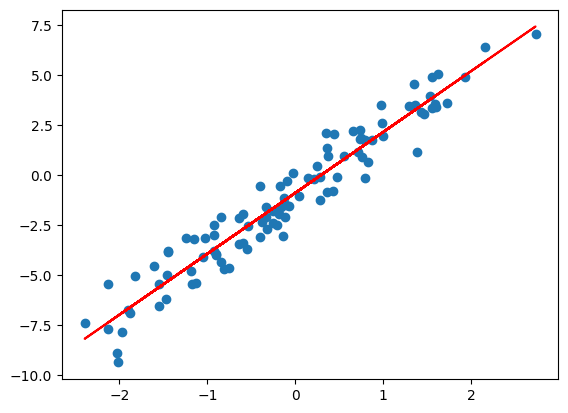

In [7]:
theta = jnp.array([1., 1.])
init_lr = 1
for i in range(1000):
    if i % 100 == 0:
        print(f"loss: {loss_fn(theta, xs, ys):<.2f}")
    theta = update(theta, xs, ys,init_lr/(1+i))

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs), color='red')

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

## JIT Compilation with JAX

When to JIT:
* It usually only saves time if the compiled function is complex and you will run it numerous times. 
* Generally, you want to jit the largest possible chunk of your computation; ideally, the entire **update** step. This gives the compiler maximum freedom to optimise.

Caching behaviour:
* JAX will only compile a function once (when first invoked), and then cache the compiled code for reuse.
* If specifying `static_argnums`, for every unique set of static arguments, JAX will compile a new version of the function and cache it separately.
* Avoid calling `jax.jit` inside loops, as this will result in a new compiled function being created and cached for every iteration of the loop. Because the cache relies on the hash of the function, it becomes problematic when equivalent functions are redefined. 

In [2]:
import jax 
from functools import partial

def unjitted_loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted_partial(x, n):
  i = 0
  while i < n:
    # Don't do this! each time the partial returns
    # a function with different hash
    i = jax.jit(partial(unjitted_loop_body))(i)
  return x + i

def g_inner_jitted_lambda(x, n):
  i = 0
  while i < n:
    # Don't do this!, lambda will also return
    # a function with a different hash
    i = jax.jit(lambda x: unjitted_loop_body(x))(i)
  return x + i

def g_inner_jitted_normal(x, n):
  i = 0
  while i < n:
    # this is OK, since JAX can find the
    # cached, compiled function
    i = jax.jit(unjitted_loop_body)(i)
  return x + i

print("jit called in a loop with partials:")
%timeit g_inner_jitted_partial(10, 20).block_until_ready()

print("jit called in a loop with lambdas:")
%timeit g_inner_jitted_lambda(10, 20).block_until_ready()

print("jit called in a loop with caching:")
%timeit g_inner_jitted_normal(10, 20).block_until_ready()

jit called in a loop with partials:
576 ms ± 91.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
jit called in a loop with lambdas:
712 ms ± 61.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
jit called in a loop with caching:
4.6 ms ± 986 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Automatic Vectorization in JAX

`jax.vmap` generate such a **vectorized** implementation of a function automatically, by **tracing** the function similarly to jax.jit, and automatically **adding batch axes** at the beginning of each input.

If the **batch dimension** is not the first, you may use the **in_axes** and **out_axes** arguments to specify the location of the batch dimension in inputs and outputs. These may be an integer if the batch axis is the same for all inputs and outputs, or lists, otherwise.

`jax.vmap` also supports the case where `only one` of the arguments is `batched`: for example, if you would like to convolve to a single set of weights w with a batch of vectors x; in this case the in_axes argument can be set to `None`

In [3]:
import jax
import jax.numpy as jnp

x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

Array([11., 20., 29.], dtype=float32)

In [11]:
xs = jnp.stack([x, x])
ws = jnp.stack([w, w])
auto_batch_convolve = jax.vmap(convolve)
print(
auto_batch_convolve(xs, ws).shape)
auto_batch_convolve(xs, ws)

(2, 3)


Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

In [9]:
auto_batch_convolve_v2 = jax.vmap(convolve, in_axes=1, out_axes=1)

xst = jnp.transpose(xs)
wst = jnp.transpose(ws)

print(xst.shape,wst.shape)
print(
auto_batch_convolve_v2(xst, wst).shape)

auto_batch_convolve_v2(xst, wst)

(5, 2) (3, 2)
(3, 2)


Array([[11., 11.],
       [20., 20.],
       [29., 29.]], dtype=float32)

In [10]:
batch_convolve_v3 = jax.vmap(convolve, in_axes=[0, None])
print(
batch_convolve_v3(xs, w).shape)
batch_convolve_v3(xs, w)
# Here w is not batched, the same w is used for all x

(2, 3)


Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

In [8]:
jitted_batch_convolve = jax.jit(auto_batch_convolve)

jitted_batch_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

## Advanced Automatic Differentiation

### One-variable functions' derivatives: 

In [19]:
import jax

f = lambda x: x**3 + 2*x**2 - 3*x + 1

dfdx = jax.grad(f)
print(jax.make_jaxpr(f)(1.))
print(jax.make_jaxpr(dfdx)(1.))

{ lambda ; a:f32[]. let
    b:f32[] = integer_pow[y=3] a
    c:f32[] = integer_pow[y=2] a
    d:f32[] = mul 2.0 c
    e:f32[] = add b d
    f:f32[] = mul 3.0 a
    g:f32[] = sub e f
    h:f32[] = add g 1.0
  in (h,) }
{ lambda ; a:f32[]. let
    b:f32[] = integer_pow[y=3] a
    c:f32[] = integer_pow[y=2] a
    d:f32[] = mul 3.0 c
    e:f32[] = integer_pow[y=2] a
    f:f32[] = integer_pow[y=1] a
    g:f32[] = mul 2.0 f
    h:f32[] = mul 2.0 e
    i:f32[] = add b h
    j:f32[] = mul 3.0 a
    k:f32[] = sub i j
    _:f32[] = add k 1.0
    l:f32[] = neg 1.0
    m:f32[] = mul 3.0 l
    n:f32[] = mul 2.0 1.0
    o:f32[] = mul n g
    p:f32[] = add_any m o
    q:f32[] = mul 1.0 d
    r:f32[] = add_any p q
  in (r,) }


In [15]:
d2fdx = jax.grad(dfdx)
d3fdx = jax.grad(d2fdx)
d4fdx = jax.grad(d3fdx)
print(dfdx(1.))
print(d2fdx(1.))
print(d3fdx(1.))
print(d4fdx(1.))

4.0
10.0
6.0
0.0


### Hessian matrix & Jacobian:

Jacobian can be computed by `jax.jacfwd` and `jax.jacrev`: corresponding to forward- and reverse-mode autodiff.

The choice depends on the relative sizes of the input and output spaces. If the input space is much larger than the output space, then reverse-mode autodiff is more efficient. If the output space is much larger than the input space, then forward-mode autodiff is more efficient.

Some tricks can be used to avoid inefficiently computing full Jacobians.

In [20]:
def hessian(f):
    return jax.jacfwd(jax.grad(f))

import jax.numpy as jnp

def f(x):
    return jnp.dot(x, x)

hessian(f)(jnp.array([1., 2., 3.]))


Array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]], dtype=float32)

### **Higher order optimization** is easy in JAX: 

In [ ]:
def meta_loss_fn(params, data):
  """Computes the loss after one step of SGD."""
  grads = jax.grad(loss_fn)(params, data)
  return loss_fn(params - lr * grads, data)

meta_grads = jax.grad(meta_loss_fn)(params, data)

Stopping gradients

Consider for instance the TD(0) (temporal difference) reinforcement learning update. Let’s assume the value estimate in a state is parameterised by a linear function.


In [22]:
# Value function and initial parameters
value_fn = lambda theta, state: jnp.dot(theta, state)
theta = jnp.array([0.1, -0.1, 0.])

# An example transition.
s_tm1 = jnp.array([1., 2., -1.])
r_t = jnp.array(1.)
s_t = jnp.array([2., 1., 0.])

# Wrong way to compute the TD loss: the gradient include the dependency of target on theta.

# def td_loss(theta, s_tm1, r_t, s_t):
#   v_tm1 = value_fn(theta, s_tm1)
#   target = r_t + value_fn(theta, s_t)
#   return -0.5 * ((target - v_tm1) ** 2)

# Right way: 
def td_loss(theta, s_tm1, r_t, s_t):
    v_tm1 = value_fn(theta, s_tm1)
    target = r_t + value_fn(theta, s_t)
    return -0.5 * ((jax.lax.stop_gradient(target) - v_tm1) ** 2)


td_update = jax.grad(td_loss)
delta_theta = td_update(theta, s_tm1, r_t, s_t)

print(delta_theta)

[ 1.2  2.4 -1.2]


In [29]:
# As a comparison, the original calculation of delta_theta is:
s_grad = jax.grad(value_fn)(theta, s_tm1)
delta_theta_original_calculation = (r_t + value_fn(theta, s_t) - value_fn(theta, s_tm1)) * s_grad

delta_theta_original_calculation # [1.2, 2.4, -1.2], same as `delta_theta`

Array([ 1.2,  2.4, -1.2], dtype=float32)

In [28]:

s_tm1 = jnp.array([1., 2., -1.])
s_t = jnp.array([2., 1., 0.])

f = lambda a,b: a.dot(b)
jax.grad(f)(s_tm1, s_t)
jax.grad(f,argnums=[0,1])(s_t, s_tm1)
# Use argnums to specify which argument to differentiate with respect to
# Default is argnums=0, means differentiate with respect to the first argument

(Array([ 1.,  2., -1.], dtype=float32), Array([2., 1., 0.], dtype=float32))

### Straight-through estimator of gradient

a trick for defining a gradient for a function that is not differentiable.

Can be directly implemented using `jax.lax.stop_gradient`

In [30]:
def f(x):
    return jnp.round(x)  # non-differentiable

def straight_through_f(x):
    # Create an exactly-zero expression with Sterbenz lemma that has
    # an exactly-one gradient.
    zero = x - jax.lax.stop_gradient(x)
    return zero + jax.lax.stop_gradient(f(x))

print("f(x): ", f(3.2))
print("straight_through_f(x):", straight_through_f(3.2))

print("grad(f)(x):", jax.grad(f)(3.2))
print("grad(straight_through_f)(x):", jax.grad(straight_through_f)(3.2))

f(x):  3.0
straight_through_f(x): 3.0
grad(f)(x): 0.0
grad(straight_through_f)(x): 1.0


### Per-example gradients

Combine `jit`, `vmap`, `grad`, In JAX we can define it in an easy & efficient way.


In [31]:
perex_grads = jax.jit(jax.vmap(jax.grad(td_loss), in_axes=(None, 0, 0, 0)))
                                            # theta, s_tm1, r_t, s_t
                                            # theta is not batched, means
                                            # We use the same theta for all samples
                                            
# Test it:
batched_s_tm1 = jnp.stack([s_tm1, s_tm1])
batched_r_t = jnp.stack([r_t, r_t])
batched_s_t = jnp.stack([s_t, s_t])

perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t)

Array([[ 1.2,  2.4, -1.2],
       [ 1.2,  2.4, -1.2]], dtype=float32)

In [32]:
dtdloss_dtheta = jax.grad(td_loss)

print(dtdloss_dtheta(theta, s_tm1, r_t, s_t))

inefficient_perex_grads = jax.vmap(dtdloss_dtheta, in_axes=(None, 0, 0, 0))

print(inefficient_perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t))

perex_grads = jax.jit(inefficient_perex_grads)

print(perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t))

%timeit inefficient_perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t).block_until_ready()
%timeit perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t).block_until_ready()


[ 1.2  2.4 -1.2]
[[ 1.2  2.4 -1.2]
 [ 1.2  2.4 -1.2]]
[[ 1.2  2.4 -1.2]
 [ 1.2  2.4 -1.2]]
9.39 ms ± 666 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.6 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## PRN in JAX

JAX’s random number generation differs from NumPy’s in important ways. The reason is that NumPy’s PRNG design makes it hard to simultaneously guarantee a number of desirable properties for JAX, specifically that code must be:

* reproducible,

* parallelizable,

* vectorisable.

Usage: generate a key, fork it, use part of them.

As in NumPy, JAX’s random module also allows sampling of vectors of numbers. However, JAX does not provide a sequential equivalence guarantee, because doing so would interfere with the vectorization on SIMD hardware

In [39]:
import jax 
from jax import random
key = random.PRNGKey(42)
subkeys = random.split(key, 3)
sequence = np.stack([random.normal(subkey) for subkey in subkeys])
print("individually:", sequence)

key = random.PRNGKey(42)
print("all at once: ", random.normal(key, shape=(3,)))

individually: [-0.04838832  0.10796154 -1.2226542 ]
all at once:  [ 0.18693547 -1.2806505  -1.5593132 ]


## Pytree

Often, we want to operate on objects that look like dicts of arrays, or lists of lists of dicts, or other nested structures. In JAX, we refer to these as **pytrees**, but you can sometimes see them called **nests**, or just trees.

Related item: `jax.tree_utils`, `jax.tree_*`

### **Concepts**

a pytree is a **container** of leaf elements and/or more **pytrees**. Containers include lists, tuples, and dicts. A leaf element is anything that’s not a pytree, e.g. an array. In other words, a pytree is just a possibly-nested standard or user-registered Python container. If nested, note that the container types do not need to match. A single “leaf”, i.e. a non-container object, is also considered a pytree.

In [40]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have:
for pytree in example_trees:
    leaves = jax.tree_util.tree_leaves(pytree)
    print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x000002CC54D3CBF0>] has 3 leaves: [1, 'a', <object object at 0x000002CC54D3CBF0>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


Common operation: 

In [43]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

jax.tree_map(lambda x: x*2, list_of_lists)

another_list_of_lists = list_of_lists
jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

Example: MLP parameters

In [45]:
import numpy as np

def init_mlp_params(layer_widths):
    params = []
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
                biases=np.ones(shape=(n_out,))
                )
        )
    return params

params = init_mlp_params([1, 128, 128, 1])
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [46]:
def forward(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):

    grads = jax.grad(loss_fn)(params, x, y)
    # Note that `grads` is a pytree with the same structure as `params`.
    # `jax.grad` is one of the many JAX functions that has
    # built-in support for pytrees.

    # This is handy, because we can apply the SGD update using tree utils:
    return jax.tree_map(
        lambda p, g: p - LEARNING_RATE * g, params, grads
    )

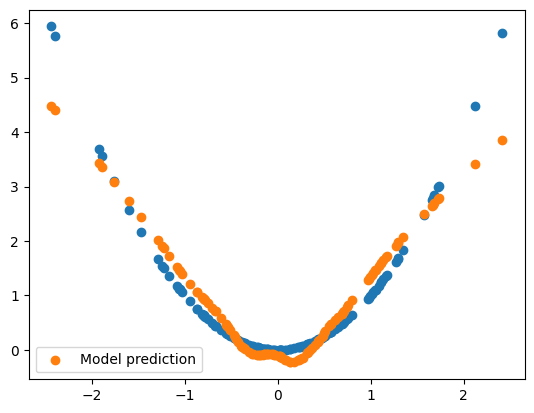

In [47]:
import matplotlib.pyplot as plt

xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(1000):
    params = update(params, xs, ys)  

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

### Key paths

In a pytree each leaf has a key path. A key path for a leaf is **a list of keys**, where the length of the list is equal to the depth of the leaf in the pytree . Each key is a **hashable** object that represents an index into the corresponding pytree node type. The type of the key depends on the pytree node type; for example, the type of keys for dicts is different from the type of keys for tuples.

![Alt text](image-4.png)

In [49]:
import collections
ATuple = collections.namedtuple("ATuple", ('name'))

tree = [1, {'k1': 2, 'k2': (3, 4)}, ATuple('foo')]
flattened, _ = jax.tree_util.tree_flatten_with_path(tree)
for key_path, value in flattened:
    print(f'Value of tree{jax.tree_util.keystr(key_path)}: {value}')
for key_path, _ in flattened:
    print(f'Key path of tree{jax.tree_util.keystr(key_path)}: {repr(key_path)}')

Value of tree[0]: 1
Value of tree[1]['k1']: 2
Value of tree[1]['k2'][0]: 3
Value of tree[1]['k2'][1]: 4
Value of tree[2].name: foo
Key path of tree[0]: (SequenceKey(idx=0),)
Key path of tree[1]['k1']: (SequenceKey(idx=1), DictKey(key='k1'))
Key path of tree[1]['k2'][0]: (SequenceKey(idx=1), DictKey(key='k2'), SequenceKey(idx=0))
Key path of tree[1]['k2'][1]: (SequenceKey(idx=1), DictKey(key='k2'), SequenceKey(idx=1))
Key path of tree[2].name: (SequenceKey(idx=2), GetAttrKey(name='name'))


### Custom Pytree Nodes
i.e. define container class

In [50]:
# Old way to define a class:
class MyContainer:
    """A named container."""

    def __init__(self, name: str, a: int, b: int, c: int):
        self.name = name
        self.a = a
        self.b = b
        self.c = c
        
jax.tree_util.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

In [ ]:
# To register our container as pytree
# We need to define a `tree_flatten` and `tree_unflatten` method

from typing import Iterable

def flatten_MyContainer(container) -> tuple[Iterable[int], str]:
    """Returns an iterable over container contents, and aux data."""
    flat_contents = [container.a, container.b, container.c]

    # we don't want the name to appear as a child, so it is auxiliary data.
    # auxiliary data is usually a description of the structure of a node,
    # e.g., the keys of a dict -- anything that isn't a node's children.
    aux_data = container.name
    return flat_contents, aux_data

def unflatten_MyContainer(
        aux_data: str, flat_contents: Iterable[int]) -> MyContainer:
    """Converts aux data and the flat contents into a MyContainer."""
    return MyContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_node(
    MyContainer, flatten_MyContainer, unflatten_MyContainer)


In [54]:

jax.tree_util.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

flattened, _ = jax.tree_util.tree_flatten_with_path([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])
for key_path, value in flattened:
    print(f'Value of tree{jax.tree_util.keystr(key_path)}: {value}')

Value of tree[0][<flat index 0>]: 1
Value of tree[0][<flat index 1>]: 2
Value of tree[0][<flat index 2>]: 3
Value of tree[1][<flat index 0>]: 4
Value of tree[1][<flat index 1>]: 5
Value of tree[1][<flat index 2>]: 6


In [56]:
# We can also define the key path version of the above container
class MyKeyPathContainer(MyContainer):
    pass

def flatten_with_keys_MyKeyPathContainer(container) -> tuple[Iterable[int], str]:
    """Returns an iterable over container contents, and aux data."""

    # GetAttrKey is a common way to express an attribute key. Users are free
    # to pick any other expression that fits their use cases the best.
    flat_contents = [(jax.tree_util.GetAttrKey('a'), container.a),
                    (jax.tree_util.GetAttrKey('b'), container.b),
                    (jax.tree_util.GetAttrKey('c'), container.c)]

    # we don't want the name to appear as a child, so it is auxiliary data.
    # auxiliary data is usually a description of the structure of a node,
    # e.g., the keys of a dict -- anything that isn't a node's children.
    aux_data = container.name
    return flat_contents, aux_data

def unflatten_MyKeyPathContainer(
        aux_data: str, flat_contents: Iterable[int]) -> MyKeyPathContainer:
    """Converts aux data and the flat contents into a MyContainer."""
    return MyKeyPathContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_with_keys(
    MyKeyPathContainer, flatten_with_keys_MyKeyPathContainer, unflatten_MyKeyPathContainer)

jax.tree_util.tree_leaves([
    MyKeyPathContainer('Alice', 1, 2, 3),
    MyKeyPathContainer('Bob', 4, 5, 6)
])

[1, 2, 3, 4, 5, 6]

In [57]:

flattened, _ = jax.tree_util.tree_flatten_with_path([
    MyKeyPathContainer('Alice', 1, 2, 3),
    MyKeyPathContainer('Bob', 4, 5, 6)
])
for key_path, value in flattened:
    print(f'Value of tree{jax.tree_util.keystr(key_path)}: {value}')

Value of tree[0].a: 1
Value of tree[0].b: 2
Value of tree[0].c: 3
Value of tree[1].a: 4
Value of tree[1].b: 5
Value of tree[1].c: 6


In [58]:
from typing import NamedTuple, Any

class MyOtherContainer(NamedTuple):
  name: str
  a: Any
  b: Any
  c: Any

# NamedTuple subclasses are handled as pytree nodes, so
# this will work out-of-the-box:
jax.tree_util.tree_leaves([
    MyOtherContainer('Alice', 1, 2, 3),
    MyOtherContainer('Bob', 4, 5, 6)
])

# Note that name is now also a child.

['Alice', 1, 2, 3, 'Bob', 4, 5, 6]

In [59]:
from typing import NamedTuple, Any

@jax.tree_util.register_static
class StaticStr(str):
  pass


class YetAnotherContainer(NamedTuple):
  name: StaticStr
  a: Any
  b: Any
  c: Any


# NamedTuple subclasses are handled as pytree nodes, so
# this will work out-of-the-box:
jax.tree_util.tree_leaves([
    YetAnotherContainer(StaticStr('Alice'), 1, 2, 3),
    YetAnotherContainer(StaticStr('Bob'), 4, 5, 6)
])

[1, 2, 3, 4, 5, 6]

### Common gotchas and patterns

https://jax.readthedocs.io/en/latest/jax-101/05.1-pytrees.html#common-pytree-gotchas-and-patterns

In [62]:
def tree_transpose(list_of_trees):
    """Convert a list of trees of identical structure into a single tree of lists."""
    return jax.tree_map(lambda *xs: list(xs), *list_of_trees)


# Convert a dataset from row-major to column-major:
episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
print(tree_transpose(episode_steps))

jax.tree_transpose(
  outer_treedef = jax.tree_util.tree_structure([0 for e in episode_steps]),
  inner_treedef = jax.tree_util.tree_structure(episode_steps[0]),
  pytree_to_transpose = episode_steps
)

{'obs': [3, 4], 't': [1, 2]}


C:\Users\test\AppData\Local\Temp\ipykernel_6664\468251687.py:10: DeprecationWarning: jax.tree_transpose is deprecated: use jax.tree_util.tree_transpose.
  jax.tree_transpose(


{'obs': [3, 4], 't': [1, 2]}

## Parallel Evaluation

`jax.pmap` to transform a function written for one device into a function that runs in parallel on multiple devices.

Keep in mind that when calling the transformed function, the size of the specified axis in arguments must not exceed the number of devices available to the host.

`jax.pmap` JIT-compiles the function given to it as part of its operation, so there is no need to additionally `jax.jit` it.

In [77]:
import jax
jax.devices()
# Should have multiple devices for this part of code

[CpuDevice(id=0)]

Hosts and devices

In [ ]:
import os
import jax
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=2'
# We can emulate a multi-device environment by setting this flag.
# Should set it before initialization.
jax.devices()

[CpuDevice(id=0), CpuDevice(id=1)]

In [64]:
import numpy as np
import jax.numpy as jnp

x = np.arange(5)
w = np.array([2., 3., 4.])

def convolve(x, w):
    output = []
    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))
    return jnp.array(output)

convolve(x, w)
n_devices = jax.local_device_count() 
xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

xs

array([[0, 1, 2, 3, 4]])

In [66]:
jax.vmap(convolve)(xs, ws)
jax.pmap(convolve)(xs, ws)

Array([[11., 20., 29.]], dtype=float32)

In [67]:
# If we were to run another parallel computation, the elements would stay on their respective devices, without incurring cross-device communication costs.
jax.pmap(convolve)(xs, jax.pmap(convolve)(xs, ws))

Array([[ 78., 138., 198.]], dtype=float32)

In [69]:
# similar to `vmap`, `pmap` also has `in_axes` and `out_axes` arguments:
jax.pmap(convolve, in_axes=(0, None))(xs, w)

Array([[11., 20., 29.]], dtype=float32)

Communication between devices

collective ops are needed. `jax.lax.p*`.

In order to use the collective ops we must specify the** name of the pmap-ed axis** through axis_name argument, and then refer to it when calling the op.

In [71]:
def normalized_convolution(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  output = jnp.array(output)
  return output / jax.lax.psum(output, axis_name='p')

jax.pmap(normalized_convolution, axis_name='p')(xs, ws)

# jax.vmap also supports axis_name, which allows jax.lax.p* operations to be used in the vectorisation context in the same way they would be used in a jax.pmap:
jax.vmap(normalized_convolution, axis_name='p')(xs, ws)

Array([[1., 1., 1.]], dtype=float32)

Nesting pmap and vmap

We need to specify different axis name for vmap and pmap.


In [ ]:
jax.vmap(jax.pmap(f, axis_name='i'), axis_name='j')
# jax.lax.psum(..., axis_name='i')

Example: Data parallelism

In [74]:
from typing import NamedTuple
import functools

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray


def init(rng) -> Params:
  """Returns the initial model params."""
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)


def loss_fn(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = params.weight * xs + params.bias
  return jnp.mean((pred - ys) ** 2)

LEARNING_RATE = 0.005

# So far, the code is identical to the single-device case. Here's what's new:


# Remember that the `axis_name` is just an arbitrary string label used
# to later tell `jax.lax.pmean` which axis to reduce over. Here, we call it
# 'num_devices', but could have used anything, so long as `pmean` used the same.
@functools.partial(jax.pmap, axis_name='num_devices')
def update(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> tuple[Params, jnp.ndarray]:
  """Performs one SGD update step on params using the given data."""

  # Compute the gradients on the given minibatch (individually on each device).
  loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

  # Combine the gradient across all devices (by taking their mean).
  grads = jax.lax.pmean(grads, axis_name='num_devices')

  # Also combine the loss. Unnecessary for the update, but useful for logging.
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  # Each device performs its own update, but since we start with the same params
  # and synchronise gradients, the params stay in sync.
  new_params = jax.tree_map(
      lambda param, g: param - g * LEARNING_RATE, params, grads)

  return new_params, loss

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

# Initialise parameters and replicate across devices.
params = init(jax.random.PRNGKey(123))
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)

def split(arr):
  """Splits the first axis of `arr` evenly across the number of devices."""
  return arr.reshape(n_devices, arr.shape[0] // n_devices, *arr.shape[1:])

# Reshape xs and ys for the pmapped `update()`.
x_split = split(xs)
y_split = split(ys)

type(x_split)

numpy.ndarray

In [75]:
def type_after_update(name, obj):
    print(f"after first `update()`, `{name}` is a", type(obj))

# Actual training loop.
for i in range(1000):

    # This is where the params and data gets communicated to devices:
    replicated_params, loss = update(replicated_params, x_split, y_split)

    # The returned `replicated_params` and `loss` are now both jax.Arrays,
    # indicating that they're on the devices.
    # `x_split`, of course, remains a NumPy array on the host.
    if i == 0:
        type_after_update('replicated_params.weight', replicated_params.weight)
        type_after_update('loss', loss)
        type_after_update('x_split', x_split)

    if i % 100 == 0:
        # Note that loss is actually an array of shape [num_devices], with identical
        # entries, because each device returns its copy of the loss.
        # So, we take the first element to print it.
        print(f"Step {i:3d}, loss: {loss[0]:.3f}")


# Plot results.

# Like the loss, the leaves of params have an extra leading dimension,
# so we take the params from the first device.
params = jax.device_get(jax.tree_map(lambda x: x[0], replicated_params))

after first `update()`, `replicated_params.weight` is a <class 'jaxlib.xla_extension.ArrayImpl'>
after first `update()`, `loss` is a <class 'jaxlib.xla_extension.ArrayImpl'>
after first `update()`, `x_split` is a <class 'numpy.ndarray'>
Step   0, loss: 6.821
Step 100, loss: 0.654
Step 200, loss: 0.236
Step 300, loss: 0.204
Step 400, loss: 0.201
Step 500, loss: 0.200
Step 600, loss: 0.200
Step 700, loss: 0.200
Step 800, loss: 0.200
Step 900, loss: 0.200


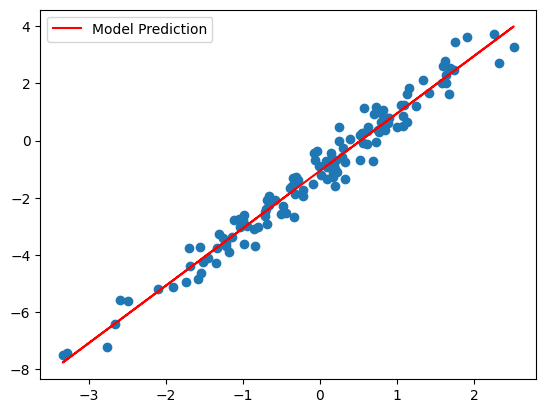

In [76]:
import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend()
plt.show()

## Stateful Computations in JAX

So, if we can’t have side effects, how do we update model parameters, the optimizer state, and use stateful layers in our models? This colab will explain this in detail, but the short answer is: with **functional programming**.

Solution:
- Explicit State. Convert Class Data into Function Arguments. (Making OOP uselesss)
- Use Library.

----------
# End